In [1]:
from sys import platform as _platform
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
#if _platform =='linux2':
#    path = '../data/data_sleep/' 
#else:
#    #mets ton path ici et ça devrait marcher :)
#    path = ""
path = "data/"

In [2]:
nrows = None
#frequencies=pd.read_csv(path+"data_frequences.csv").drop("Unnamed: 0", axis=1)
frequencies=pd.read_csv(path+"fft_eeg.csv", nrows = nrows)
frequencies_acc =pd.read_csv(path+"fft_acc.csv", nrows = nrows)

stats_acc=pd.read_csv(path+"stats_acc.csv", nrows = nrows)
stats_egg=pd.read_csv(path+"stats_eeg.csv", nrows = nrows)
stats=pd.concat([stats_acc, stats_egg], axis=1)
#ACC_feats =pd.read_csv(path+"ACC_feats.csv").drop("Unnamed: 0", axis=1)
labels=pd.read_csv(path+"challenge_output_data_training_file_sleep_stages_classification.csv", sep=";", nrows = nrows)
#stats = pd.concat([stats.filter(regex="EEG[0-9]*"),stats_ACC], axis=1)
#stats = pd.concat([stats,stats_ACC], axis=1)

frequencies_test=pd.read_csv(path+"fft_eeg_test.csv")
frequencies_acc_test =pd.read_csv(path+"fft_acc_test.csv")
#ACC_feats_test =pd.read_csv(path+"ACC_feats_test.csv").drop("Unnamed: 0", axis=1)
stats_acc_test=pd.read_csv(path+"stats_acc_test.csv")
stats_egg_test=pd.read_csv(path+"stats_eeg_test.csv")
stats_test=pd.concat([stats_acc_test, stats_egg_test], axis=1)

In [3]:
def select_freq_names(low, high, X_columns, prefix = ''):
    return [name for name in X_columns 
            if len(name.split('q'))==2 
            and name.split('freq')[0] == prefix
            and low<=float(name.split('freq')[1]) 
            and high>= float(name.split('freq')[1])]
def group_frequencies(name, low, high, frequencies, prefix = ''):
    frequencies[name]=(1./(high-low) * (frequencies[select_freq_names(low,high,frequencies.columns,prefix)])).sum(axis=1)

In [4]:

#frequencies["delta"]=frequencies[select_freq_names(0,3,frequencies.columns)].sum(axis=1)
#frequencies["delta"]=frequencies[select_freq_names(0,3.99,frequencies.columns)].sum(axis=1)
#frequencies["theta"]=frequencies[select_freq_names(4,7.5,frequencies.columns)].sum(axis=1)
#frequencies["alpha"]=frequencies[select_freq_names(7.5,13.99,frequencies.columns)].sum(axis=1)
#frequencies["beta"]=frequencies[select_freq_names(14,50,frequencies.columns)].sum(axis=1)

def make_new_feats(frequencies):
    group_frequencies("delta1", 0.4, 0.8, frequencies)
    group_frequencies("delta2", 0.81, 1.99, frequencies)
    group_frequencies("delta3", 2, 3.99, frequencies)
    group_frequencies("theta1", 4, 5, frequencies)
    group_frequencies("theta2", 5, 7.499, frequencies)
    group_frequencies("alpha1", 7.5, 9.5, frequencies)
    group_frequencies("alpha2", 9.5, 10.499, frequencies)
    group_frequencies("alpha3", 10.5, 13.5, frequencies)
    group_frequencies("beta", 14, 20, frequencies)
    group_frequencies("beta2", 20, 30, frequencies)
    group_frequencies("beta3", 31, 50, frequencies)



In [5]:
def regroup_acc_freq (frequencies_acc):
    for prefix in ['ACC_X.','ACC_Y.','ACC_Z.']:
        group_frequencies(prefix+"smaller_one",0.01,1, frequencies_acc,prefix)
        group_frequencies(prefix+"one_to_two",1.01,2, frequencies_acc,prefix)
        group_frequencies(prefix+"two_to_three",2.01,3, frequencies_acc,prefix)
        group_frequencies(prefix+"three_to_four",3.01,4, frequencies_acc,prefix)
        group_frequencies(prefix+"more_four",4,10, frequencies_acc,prefix)




In [6]:
def make_new_features(f, stat, f_acc):
    new_feat = ["delta1","delta2","delta3", 'theta1', 'theta2', 'alpha1','alpha2','alpha3', 'beta','beta2','beta3']
    make_new_feats(f)
    
    prefixes = ['ACC_X.','ACC_Y.','ACC_Z.']
    regroup_acc_freq (f_acc)
    frequencies_acc2 = f_acc[[prefix+ x for x in["smaller_one","one_to_two","two_to_three",'more_four']for prefix in prefixes]]
    
    return  pd.concat([f[new_feat], stat, frequencies_acc2], axis=1)

In [7]:
train = make_new_features(frequencies, stats, frequencies_acc)
test = make_new_features(frequencies_test, stats_test, frequencies_acc_test)

In [8]:
labels = labels.drop(train[train["delta1"] > 10000].index)
train=train.drop(train[train["delta1"] > 10000].index)

In [9]:
train.describe()

,delta1,delta2,delta3,theta1,theta2,alpha1,alpha2,alpha3,beta,beta2,beta3,ACC_X_quantile_0,ACC_X_quantile_10,ACC_X_quantile_20,ACC_X_quantile_30,ACC_X_quantile_40,ACC_X_quantile_50,ACC_X_quantile_60,ACC_X_quantile_70,ACC_X_quantile_80,ACC_X_quantile_90,ACC_X_quantile_100,mean_ACC_X,var_ACC_X,skew_ACC_X,kurt_ACC_X,ACC_Y_quantile_0,ACC_Y_quantile_10,ACC_Y_quantile_20,ACC_Y_quantile_30,ACC_Y_quantile_40,ACC_Y_quantile_50,ACC_Y_quantile_60,ACC_Y_quantile_70,ACC_Y_quantile_80,ACC_Y_quantile_90,ACC_Y_quantile_100,mean_ACC_Y,var_ACC_Y,skew_ACC_Y,kurt_ACC_Y,ACC_Z_quantile_0,ACC_Z_quantile_10,ACC_Z_quantile_20,ACC_Z_quantile_30,ACC_Z_quantile_40,ACC_Z_quantile_50,ACC_Z_quantile_60,ACC_Z_quantile_70,ACC_Z_quantile_80,ACC_Z_quantile_90,ACC_Z_quantile_100,mean_ACC_Z,var_ACC_Z,skew_ACC_Z,kurt_ACC_Z,EEG_quantile_0,EEG_quantile_10,EEG_quantile_20,EEG_quantile_30,EEG_quantile_40,EEG_quantile_50,EEG_quantile_60,EEG_quantile_70,EEG_quantile_80,EEG_quantile_90,EEG_quantile_100,mean_EEG,var_EEG,skew_EEG,kurt_EEG,EEG_through_0,EEG_through_mean,ACC_X.smaller_one,ACC_Y.smaller_one,ACC_Z.smaller_one,ACC_X.one_to_two,ACC_Y.one_to_two,ACC_Z.one_to_two,ACC_X.two_to_three,ACC_Y.two_to_three,ACC_Z.two_to_three,ACC_X.more_four,ACC_Y.more_four,ACC_Z.more_four
count,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,3.112800e+04,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,3.112800e+04,31128.000000,3.112800e+04,31128.000000,31128.000000,3.112800e+04,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,3.112800e+04,31128.000000,3.112800e+04,31128.000000,31128.000000,3.112800e+04,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,3.112800e+04,31128.000000,3.112800e+04,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000
mean,56.613403,17.108971,6.582232,4.263254,3.173376,2.685000,2.378316,1.971060,1.121987,0.786170,0.569901,-7.423143e+04,-70100.228579,-62274.560420,-45206.892940,-24473.196606,-2680.118137,19442.707510,41191.771991,62109.467397,77356.688846,8.218016e+04,537289.767292,3.330339e+10,-0.024520,1.037846,-7.709339e+04,-73117.934886,-64881.307901,-46638.038636,-25246.630801,-2388.639676,20462.128903,43432.320419,64535.899020,79785.213543,8.457110e+04,585567.728568,3.488700e+10,-0.039890,1.229492,-7.832675e+04,-72463.289367,-65682.832822,-48826.994779,-26349.672310,-2997.177483,20555.310290,44427.157704,65843.010144,81056.082081,8.571842e+04,467418.657534,3.552050e+10,0.056374,1.169261,-65.505027,-24.063934,-14.710690,-8.834041,-4.245952,-0.122066,4.017014,8.652046,14.597249,24.079254,65.825801,-0.307710,797.309588,0.042310,1.887117,266.305834,266.226902,55259.539742,59062.267077,68200.990046,45071.702893,46031.113001,52877.909848,58956.644160,60439.322980,57636.250844,6722.977664,6420.037437,7003.176828
std,66.011284,12.740004,3.725917,2.302072,1.616906,1.393210,1.347707,0.933419,0.721856,0.738372,0.742020,2.306999e+05,222170.019983,199718.355252,147324.530336,82395.494080,25886.803158,66644.654971,133777.995479,199300.938450,245556.823334,2.565174e+05,576191.926545,1.071636e+11,0.977889,8.421208,2.359178e+05,227945.872186,204623.232933,149742.182054,85528.309934,29113.269698,69365.836318,139389.669428,204306.058871,249915.459529,2.590731e+05,657679.823820,1.104890e+11,1.113460,9.874830,2.358901e+05,223627.607223,206070.935747,157886.478235,89432.495741,28433.521075,69322.238095,142815.660279,207435.089828,252449.443976

In [10]:
test.describe()

,delta1,delta2,delta3,theta1,theta2,alpha1,alpha2,alpha3,beta,beta2,beta3,ACC_X_quantile_0,ACC_X_quantile_10,ACC_X_quantile_20,ACC_X_quantile_30,ACC_X_quantile_40,ACC_X_quantile_50,ACC_X_quantile_60,ACC_X_quantile_70,ACC_X_quantile_80,ACC_X_quantile_90,ACC_X_quantile_100,mean_ACC_X,var_ACC_X,skew_ACC_X,kurt_ACC_X,ACC_Y_quantile_0,ACC_Y_quantile_10,ACC_Y_quantile_20,ACC_Y_quantile_30,ACC_Y_quantile_40,ACC_Y_quantile_50,ACC_Y_quantile_60,ACC_Y_quantile_70,ACC_Y_quantile_80,ACC_Y_quantile_90,ACC_Y_quantile_100,mean_ACC_Y,var_ACC_Y,skew_ACC_Y,kurt_ACC_Y,ACC_Z_quantile_0,ACC_Z_quantile_10,ACC_Z_quantile_20,ACC_Z_quantile_30,ACC_Z_quantile_40,ACC_Z_quantile_50,ACC_Z_quantile_60,ACC_Z_quantile_70,ACC_Z_quantile_80,ACC_Z_quantile_90,ACC_Z_quantile_100,mean_ACC_Z,var_ACC_Z,skew_ACC_Z,kurt_ACC_Z,EEG_quantile_0,EEG_quantile_10,EEG_quantile_20,EEG_quantile_30,EEG_quantile_40,EEG_quantile_50,EEG_quantile_60,EEG_quantile_70,EEG_quantile_80,EEG_quantile_90,EEG_quantile_100,mean_EEG,var_EEG,skew_EEG,kurt_EEG,EEG_through_0,EEG_through_mean,ACC_X.smaller_one,ACC_Y.smaller_one,ACC_Z.smaller_one,ACC_X.one_to_two,ACC_Y.one_to_two,ACC_Z.one_to_two,ACC_X.two_to_three,ACC_Y.two_to_three,ACC_Z.two_to_three,ACC_X.more_four,ACC_Y.more_four,ACC_Z.more_four
count,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,3.045800e+04,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,3.045800e+04,30458.000000,3.045800e+04,30458.000000,30458.000000,3.045800e+04,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,3.045800e+04,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,3.045800e+04,30458.000000,3.045800e+04,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000
mean,51.873624,17.992502,6.794295,4.340244,3.167898,2.499432,2.196317,1.872309,1.083713,0.781358,0.563860,-1.145230e+05,-111048.677018,-100698.254404,-76367.358002,-42781.896587,-7082.730902,29306.899186,65905.320313,101122.176745,129758.757400,1.377721e+05,678133.310874,5.457041e+10,0.007856,0.503843,-1.222342e+05,-116595.967467,-102236.230455,-73437.622626,-39340.833020,-3954.962660,31869.319386,67578.047117,100848.793363,127765.414439,136174.835741,674523.009937,5.458737e+10,0.035224,0.809234,-116153.658731,-112442.934588,-102521.749192,-78800.863642,-44705.219286,-7962.073985,30023.007365,67938.846590,104098.899370,131597.606695,1.419687e+05,581850.570548,5.574086e+10,0.041560,0.600053,-63.043131,-22.319276,-13.707544,-8.295338,-4.013803,-0.125879,3.784794,8.128503,13.610392,22.362700,64.487093,-0.329917,618.463526,0.059365,1.787492,295.440935,295.697649,88299.482826,88500.440793,95394.274575,81514.311799,73358.578653,89083.058384,92921.692146,89994.768631,98861.250739,10914.984852,10595.137854,11014.606995
std,54.592059,13.205135,3.736462,2.131689,1.404761,1.241717,1.140811,0.832338,0.544895,0.509729,0.592141,2.724327e+05,267295.351552,243833.494474,188134.274879,109468.373677,36720.401592,77956.123775,162953.684259,246088.905634,312813.442477,3.274585e+05,576678.553613,1.328382e+11,0.759419,6.397556,2.873461e+05,277707.940705,246498.443169,180289.221161,101464.489926,35038.250351,82607.392994,164866.027756,243061.047349,305367.062589,320491.500262,646824.532816,1.317086e+11,0.979405,9.189251,271166.278828,266884.641525,245885.597453,192705.824199,113057.158309,36273.745121,78411.644621,166513.318797,251337.

In [11]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
y_train = labels['TARGET']
X = train.drop(["skew_ACC_X","skew_ACC_Y", "skew_ACC_Z","ID"], axis=1)
X_t = test.drop(["skew_ACC_X","skew_ACC_Y", "skew_ACC_Z","ID"], axis=1)
#X, X_t, y_train, y_test = train_test_split(
#    X, labels["TARGET"], test_size=0.2)

scaler = StandardScaler().partial_fit(X)
scaler = StandardScaler().partial_fit(X_t)
X_train = scaler.transform(X)
X_test = scaler.transform(X_t)
X_columns = train.columns

In [12]:
%%time
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import cohen_kappa_score
et = ExtraTreesClassifier(random_state = 42,n_estimators=1000, max_depth= 29, n_jobs = 3)#, class_weight = 'balanced')
et.fit(X_train, y_train)
predicted_label = et.predict(X_test)

#print("Extra Random Trees - accuracy Score on test_data : ", accuracy_score(y_test, predicted_label))
#print("Extra Random Trees - kappa Score on test_data : ", cohen_kappa_score(y_test, predicted_label))
print("Extra Random Trees - kappa Score on train data : ", cohen_kappa_score(y_train, et.predict(X_train)))

('Extra Random Trees - kappa Score on train data : ', 0.999045251884077)
CPU times: user 3min 41s, sys: 3.47 s, total: 3min 44s
Wall time: 1min 19s


In [13]:
#from sklearn.metrics import accuracy_score
#print("Extra Random Trees - accuracy Score on test_data : ", accuracy_score(y_test, predicted_label))
#print("Extra Random Trees - kappa Score on test_data : ", cohen_kappa_score(y_test, predicted_label))

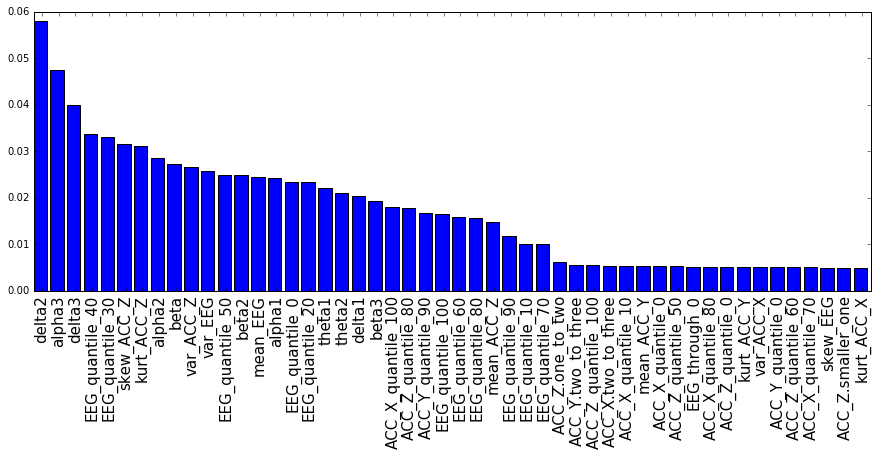

In [14]:
plt.figure(figsize=(15, 5))

ordering = np.argsort(et.feature_importances_)[::-1][:50]

importances = et.feature_importances_[ordering]
feature_names = X_columns[ordering]

x = np.arange(len(feature_names))
plt.bar(x, importances)
plt.xticks(x + 0.5, feature_names, rotation=90, fontsize=15);

In [15]:
%%time
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(et, X_train, y_train, cv=5, scoring="accuracy",n_jobs=3)
print("accuracy: {:.4f} +/-{:.4f}".format(
    np.mean(scores), np.std(scores)))

accuracy: 0.8486 +/-0.0041
CPU times: user 404 ms, sys: 257 ms, total: 661 ms
Wall time: 5min 3s


In [16]:
%%time
from sklearn.ensemble import GradientBoostingClassifier
gbc=GradientBoostingClassifier(
    n_estimators=500, 
    random_state=42,
    max_depth=18,
#    max_features=0.6,
#    subsample=0.9,
    learning_rate=0.01,
    verbose=0.5
)
gbc=GradientBoostingClassifier(
    n_estimators=200, 
    random_state=42,
    max_depth=15,
    max_features=0.6,
    subsample=0.9,
    learning_rate=0.05,
    verbose=0.5
)
from sklearn.cross_validation import cross_val_score
#scores = cross_val_score(gbc, X_train, y_train, cv=5, scoring="accuracy",n_jobs=3)
#print("accuracy: {:.4f} +/-{:.4f}".format(
#    np.mean(scores), np.std(scores)))



CPU times: user 136 µs, sys: 0 ns, total: 136 µs
Wall time: 127 µs


In [17]:
gbc.fit(X_train,y_train)
predicted_label = gbc.predict(X_test)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       36838.3466         348.3679          107.33m
         2       33343.6578         287.7822          125.13m
         3       30351.9483         246.5878          136.83m
         4       27753.7907         212.6100          144.61m
         5       25432.2409         187.9674          149.12m
         6       23382.2161         169.4309          152.53m
         7       21531.0444         151.6061          159.21m
         8       19895.4266         135.6104          165.87m
         9       18389.8429         121.7894          171.78m
        10       17025.2508         109.6186          173.92m
        11       15779.7884          98.8039          187.34m
        12       14625.6101          90.7978          197.68m
        13       13587.7822          83.1466          198.23m
        14       12598.7937          73.2420          196.16m
        15       11722.6725          68.6864          195.73m
       

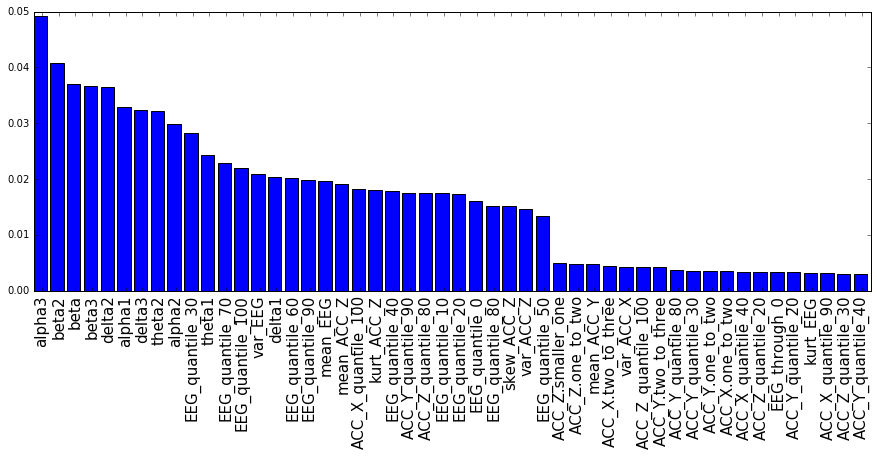

In [19]:
plt.figure(figsize=(15, 5))

ordering = np.argsort(gbc.feature_importances_)[::-1][:50]

importances = gbc.feature_importances_[ordering]
feature_names = X_columns[ordering]

x = np.arange(len(feature_names))
plt.bar(x, importances)
plt.xticks(x + 0.5, feature_names, rotation=90, fontsize=15);

In [25]:
prob_et = et.predict_proba(X_test)
prob_gbc = gbc.predict_proba(X_test)

In [26]:
print prob_et
print prob_gbc

[[  1.30000000e-02   1.50000000e-02   6.03537037e-01   5.02083333e-03
    3.63442130e-01]
 [  3.88671282e-02   4.03924821e-05   4.90643864e-01   4.36253176e-01
    3.41954401e-02]
 [  5.36132274e-03   1.86852224e-02   5.38774971e-01   1.88229060e-02
    4.18355578e-01]
 ..., 
 [  1.59049662e-03   5.80444115e-03   6.66854195e-01   8.01639322e-02
    2.45586935e-01]
 [  1.04600931e-03   7.06873036e-06   1.73359684e-01   8.22574251e-01
    3.01298701e-03]
 [  2.39855254e-02   6.13060102e-02   6.30246536e-01   5.23203606e-03
    2.79229893e-01]]
[[  8.98009843e-04   4.63478945e-03   7.83535518e-01   3.33530713e-04
    2.10598152e-01]
 [  5.34381745e-04   4.52996337e-04   6.81744657e-01   3.16732034e-01
    5.35931740e-04]
 [  3.82929228e-04   3.48010576e-04   8.88786531e-01   3.72557901e-04
    1.10109971e-01]
 ..., 
 [  1.11539433e-04   1.21332637e-04   9.96500247e-01   2.14058950e-04
    3.05282225e-03]
 [  2.38521152e-05   2.26536343e-05   2.93836116e-04   9.99624853e-01
    3.48048659e

In [42]:
weighted_prob = (prob_gbc + prob_et)

In [43]:
predicted_label = np.apply_along_axis(lambda x: np.argmax(x),1,weighted_prob)

In [44]:
def make_submission(predicted_label, name = 'submit.csv'):
    ids = pd.read_csv('../data/data_sleep/input_test.csv', usecols= ['ID'])
    #ids = pd.DataFrame()
    #ids ["ID"]= test["ID"]
    ids["TARGET"] = pd.Series(predicted_label).astype(float)
    #ids['TARGET']= ids['TARGET'].astype(int)
    ids.to_csv(name,index=False)

In [45]:
make_submission(predicted_label)

In [46]:
predicted_label_train = et.predict(X_train)

In [47]:
import collections
print collections.Counter(predicted_label), collections.Counter(y_train)

Counter({2: 16856, 3: 9843, 4: 3383, 0: 339, 1: 37}) Counter({2.0: 15334, 3.0: 9640, 4.0: 4385, 0.0: 1341, 1.0: 428})


In [ ]:
import collections
print collections.Counter(predicted_label), collections.Counter(y_train)

In [ ]:
X_train.shape, X_test.shape

In [82]:
31129 - 6130

24999